In [40]:
import cv2
import numpy as np
import os
import random as rd
import matplotlib.pyplot as plt

In [41]:
def readImages(directory):
    images_name = []
    images = []
    images_r, images_g, images_b = [], [], []
    images_rgb = [images_r, images_g, images_b]
    for filename in os.listdir(directory):
        images_name.append( directory + '/' + filename)
    images_name = sorted(images_name)
    print(images_name)
    for i in images_name:
        images.append(cv2.imread(i))
    alignMTB = cv2.createAlignMTB()
    alignMTB.process(images, images)
    for img in images:
        img = cv2.resize(img, (0,0), fx=0.3, fy=0.3) 
        b, g, r = cv2.split(img)
        images_r.append(np.array(r))
        images_g.append(np.array(b))
        images_b.append(np.array(g))
        # cv2.imwrite("img.png", cv2.merge((b,g,r)))
        # images_rgb.append(cv2.cvtColor(images[-1], cv2.COLOR_BGR2RGB))
    images_r, images_g, images_b = np.array(images_r), np.array(images_g), np.array(images_b)
    return images, images_rgb

In [42]:
def MLT_alignment(images, template):
    def compute_greyvalue(img_rgb):
        grey_img = np.zeros(img_rgb[0].shape)
        grey_img = (54 * img_rgb[0] + 183 * img_rgb[1] + 19 * img_rgb[2]) / 256
        return grey_img
    def compute_bitmap(grey_img):
        threshold = np.median(grey_img)
        tb, eb = np.zeros(grey_img.shape), np.zeros(grey_img.shape)
        for i in range(len(grey_img)):
            for j in range(len(grey_img[0])):
                if(abs(grey_img[i][j] - threshold) < 10):
                    eb[i][j] = 0
                if(grey_img[i][j] > threshold):
                    tb[i][j] = 1
        return tb, eb
    def GetExpShift(img1, img2, shift_count):
        # min_err, cur_shift[2]
        tb1, eb1 = compute_bitmap(img1)
        tb2, eb2 = compute_bitmap(img2)
        if(shift_count > 0):
            sml_img1 = cv2.resize(img1, (0,0), fx=0.5, fy=0.5) 
            sml_img2 = cv2.resize(img2, (0,0), fx=0.5, fy=0.5)
            cur_shift = GetExpShift(sml_img1, sml_img2, shift_bits - 1)
            cur_shift[0] *= 2
            cur_shift[1] *= 2
        else:
            cur_shift[0] = cur_shift[1] = 0
        min_err = len(img1) * len(img1[0])
        for i in range(len(img1)):
            for j in range(len(img1[0])):
                xs = cur_shift[0] + i;
                ys = cur_shift[1] + j;
                shifted_tb2 = np.zeros(img1.shape)
                shifted_eb2 = np.zeros(img1.shape)
                M = np.float32([[1,0, xs],[0,1,ys]])
                shifted_tb2 = cv2.warpAffine(tb2 ,M, img1.shape)
                shifted_eb2 = cv2.warpAffine(eb2 ,M, img1.shape)
                
                diff_b = np.logical_xor(tb1, shifted_tb2)
                diff_b = np.logical_and(diff_b, eb1)
                diff_b = np.logical_and(diff_b, shifted_eb2)
                err = np.sum(diff_b);
                if (err < min_err):
                    shift_ret[0] = xs;
                    shift_ret[1] = ys;
                    min_err = err;
        return shift_ret

In [43]:
def sampleZ(images_1c, MAX_intensity):
    images = images_1c
    intensity_range = MAX_intensity + 1
    Z = np.zeros((intensity_range, len(images)), dtype = int)
    # src_img = images[rd.randrange(len(images))]
    src_img = images[0]
    for intensity in range(intensity_range):
        rows, cols = np.where(src_img == intensity)
        if(len(rows) == 0):
            rows, cols = np.where(images[1] == intensity)
            if(len(rows) == 0):
                continue
        idx = rd.randrange(len(rows))
        r, c = rows[idx], cols[idx]
        for img_idx in range(len(images)):
            Z[intensity, img_idx] = images[img_idx][r][c]
    return Z

In [44]:
def show_images(images):
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    for p in range(len(images)):
        r = int(p / 5)
        c = int(p % 5)
        axes[r][c].imshow(images[p])
    plt.show()

In [45]:
def intensity_weighting(pix_value, MAX_intensity):
    return(min(pix_value, MAX_intensity - pix_value))

In [46]:
def intensityAdjustment(image, template):
    g, b, r = cv2.split(image)
    tg, tb, tr = cv2.split(template)
    b *= np.average(tb) / np.nanmean(b)
    g *= np.average(tg) / np.nanmean(g)
    r *= np.average(tr) / np.nanmean(r)
    # image = np.average(template) / np.nanmean(image) * image
    image = cv2.merge((g,b,r))
    return image
# intensityAdjustment(output, images[len(images) // 2])

In [47]:
from tqdm import tqdm_notebook as tqdm
def radiance_map_1c(images_1c, shutter_times, response_curve, weighting_function):
    images = images_1c;
    rad_map = np.zeros(images[0].shape);
    for i in tqdm(range(len(images[0]))):
        for j in range(len(images[0][0])):
            g = np.array( [response_curve[images[n][i][j]] for n in range(len(images))] )
            w = np.array( [weighting_function(images[n][i][j], 255) for n in range(len(images))] )
            SumW = np.sum(w)
            if SumW > 0:
                rad_map[i][j] = np.sum(w * (g - shutter_times) / SumW)
            else:
                idx = rd.randrange(len(images))
                rad_map[i][j] = g[idx] - shutter_times[idx]
    return rad_map

In [48]:
def computeResponseCurve(intensity_samples, log_exposures, slambda, weighting_function):
    z_min, z_max = 0, 255
    intensity_range = z_max - z_min
    num_samples = intensity_samples.shape[0]
    num_images = len(log_exposures)

    A = np.zeros((num_images * num_samples + intensity_range, num_samples + intensity_range + 1), dtype=np.float64)
    b = np.zeros((num_images * num_samples + intensity_range, 1), dtype=np.float64)

    row = 0
    for i in range(num_samples):
        for j in range(num_images):
            z_ij = intensity_samples[i, j]
            w_ij = weighting_function(z_ij, 255)
            A[row, z_ij] = w_ij
            A[row, (intensity_range + 1) + i] = -w_ij
            b[row, 0] = w_ij * log_exposures[j]
            row += 1

    for z_k in range(z_min + 1, z_max):
        w_k = weighting_function(z_k, 255)
        A[row, z_k - 1] = w_k * slambda
        A[row, z_k    ] = -2 * w_k * slambda
        A[row, z_k + 1] = w_k * slambda
        row += 1

    A[row, intensity_range // 2] = 1
    inv_A = np.linalg.pinv(A)
    x = np.dot(inv_A, b)
   
    g = x[0: intensity_range + 1]
    return g[:, 0]

In [49]:
def gammaToneMapping(image):
    gamma = 0.8
    image_corrected = cv2.pow(image/255., 1.0/gamma)
    return image_corrected

In [50]:
#import numpy as np
#from random import random
#from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image

def gaussian(x, sigma):
    return (1.0 / (2 * np.pi * (sigma ** 2))) * np.exp(- (x ** 2) / (2 * sigma ** 2))


def bilateral_filter(input_image, output_image, x, y, filter_size):
    w_sum = 0
    denoised_intensity = 0
    sigma_r = 1000
    sigma_d = 2000
    h = input_image.shape[0]
    w = input_image.shape[1]
    for i in range(-filter_size, filter_size + 1):
        for j in range(-filter_size, filter_size + 1):
            if x + i >= h or x + i < 0 or y + j >= w or y + j < 0:
                continue
            fr = gaussian(input_image[x + i][y + j] - input_image[x][y], sigma_r)
            gs = gaussian(np.linalg.norm([i, j]), sigma_d)
            w =  fr * gs
            denoised_intensity += w * input_image[x + i][y + j]
            w_sum += w
    denoised_intensity /= w_sum
    #print(denoised_intensity)
    return denoised_intensity
    #print(output_image[x, y])



def bilateral_func(input_image):
    ## functions
    def bilateral(input_image):
        filter_size = 2
        output_image = np.zeros(input_image.shape)
        h = input_image.shape[0]
        w = input_image.shape[1]
        for i in range(h):
            for j in range(w):
                output_image[i, j] = bilateral_filter(input_image, output_image,i, j, filter_size)
                #print(output_image[i, j])
        return output_image

    def bilateral_filter(input_image, output_image, x, y, filter_size):
        w_sum = 0
        denoised_intensity = 0
        sigma_r = 1000
        sigma_d = 2000
        h = input_image.shape[0]
        w = input_image.shape[1]
        for i in range(-filter_size, filter_size + 1):
            for j in range(-filter_size, filter_size + 1):
                if x + i >= h or x + i < 0 or y + j >= w or y + j < 0:
                    continue
                fr = gaussian(input_image[x + i][y + j] - input_image[x][y], sigma_r)
                gs = gaussian(np.linalg.norm([i, j]), sigma_d)
                w =  fr * gs
                denoised_intensity += w * input_image[x + i][y + j]
                w_sum += w
        denoised_intensity /= w_sum
        #print(denoised_intensity)
        return denoised_intensity
        #print(output_image[x, y])
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    R = input_image[0]
    G = input_image[2]
    B = input_image[1]
    #intensity = 1/61 * (20 * R + 40 * G + B)
    intensity = 0.2126 * R + 0.7152 * G + 0.0722 * B
    print('intensity array ', intensity)
    axes[0][0].imshow(Image.fromarray(intensity))
    r = R / intensity
    g = G / intensity
    b = B / intensity
    log_intensity = np.log(intensity)
    log_base = bilateral(log_intensity)
    log_detail = log_intensity - log_base
    print('base array',log_base)
    print('detail array',log_detail)
    axes[0][1].imshow(Image.fromarray(np.exp(log_base)))
    axes[1][0].imshow(Image.fromarray(np.exp(log_detail)))
    targetContrast = np.log10(5)
    tragetContrast = 20
    compressionfactor = targetContrast / (np.max(log_base) - np.min(log_base))
    print('compressionfactor',compressionfactor)
    compressionfactor = 0.85
    log_abs_scale = np.max(log_base) * compressionfactor
    print('log absolute scale', log_abs_scale)
    log_output = log_base * compressionfactor + log_detail# - log_abs_scale
    axes[1][1].imshow(Image.fromarray(np.exp(log_output)), cmap = "spring")
    print('log output', log_output)
    R_out = r * np.exp(log_output)
    G_out = g * np.exp(log_output)
    B_out = b * np.exp(log_output)
    plt.title("Bilateral Base")
    # plt.savefig("result_images/Base1.png")
    plt.show()
    return [R_out, B_out, G_out]#np.concatenate((R_out, G_out, B_out), axis = 2)

In [51]:
# if RadMap hasn't been calculated, send RadMap = []
def CreateHdrImage(images_rgb, MAX_intensity, shutter_times, WeightedIntensity, ToneMappingFunction, RadMap):
    Z_rgb, RespCurve, output = [], [], []
    SLambda = 200
    
    # intensity sampling
    Z_rgb = list(map(sampleZ, images_rgb, [MAX_intensity] * 3))
    
    # response curve
    RespCurve = list(map(computeResponseCurve, Z_rgb, [shutter_times] * 3, [SLambda] * 3, [WeightedIntensity] * 3))
    #RespCurve = [-1 * curve for curve in RespCurve]
    for curve in RespCurve:
        plt.plot(curve)
    plt.legend()
    plt.title("Response Curve")
    plt.show()
    # Calculate Radiance Map if RadMap is an empty list
    if len(RadMap) == 0:
        RadMap = list(map(radiance_map_1c, images_rgb, [shutter_times] * 3, RespCurve, [WeightedIntensity] * 3))
    
    # normalize and Tonemapping
    for i in range(3):
        output.append(cv2.normalize(np.exp(RadMap[i]), np.array([]), alpha=0, beta=255, norm_type=cv2.NORM_MINMAX))
    
    output = bilateral_func(output)
    output = list(map(ToneMappingFunction, output))
    for i in range(3):
        output[i] = cv2.normalize(output[i], np.array([]), alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    result_image = cv2.merge((output[1], output[2], output[0]))
    
    # intensity adjustment
    result_image= intensityAdjustment(result_image, images[0])
    
    return result_image, RadMap

In [52]:
# balcony_times = np.array([1/400, 1/250, 1/100, 1/40, 1/25, 1/8, 1/3], dtype = float)
# memorial_list = [ 2 ** 10, 2 ** 9, 2 ** 8, 2 ** 7, 
#                  2 ** 6, 2 ** 5, 2 ** 4, 2 ** 3, 
#                  2 ** 2, 2 ** 1, 2 ** (0), 2 ** (-1), 
#                  2 ** (-2), 2 ** (-3), 2 ** (-4), 2 ** (-5)]
# memorial_times = np.array(shutter_list, dtype=np.float32)
# living_room_times = np.array([1/160, 1/125, 1/80, 1/60, 1/40, 1/15], dtype = float)

['testing_images/View2/view2_1.JPG', 'testing_images/View2/view2_10.JPG', 'testing_images/View2/view2_15.JPG', 'testing_images/View2/view2_1_10.JPG', 'testing_images/View2/view2_1_25.JPG', 'testing_images/View2/view2_1_5.JPG', 'testing_images/View2/view2_1_50.JPG', 'testing_images/View2/view2_2.5.JPG', 'testing_images/View2/view2_20.JPG', 'testing_images/View2/view2_5.JPG']


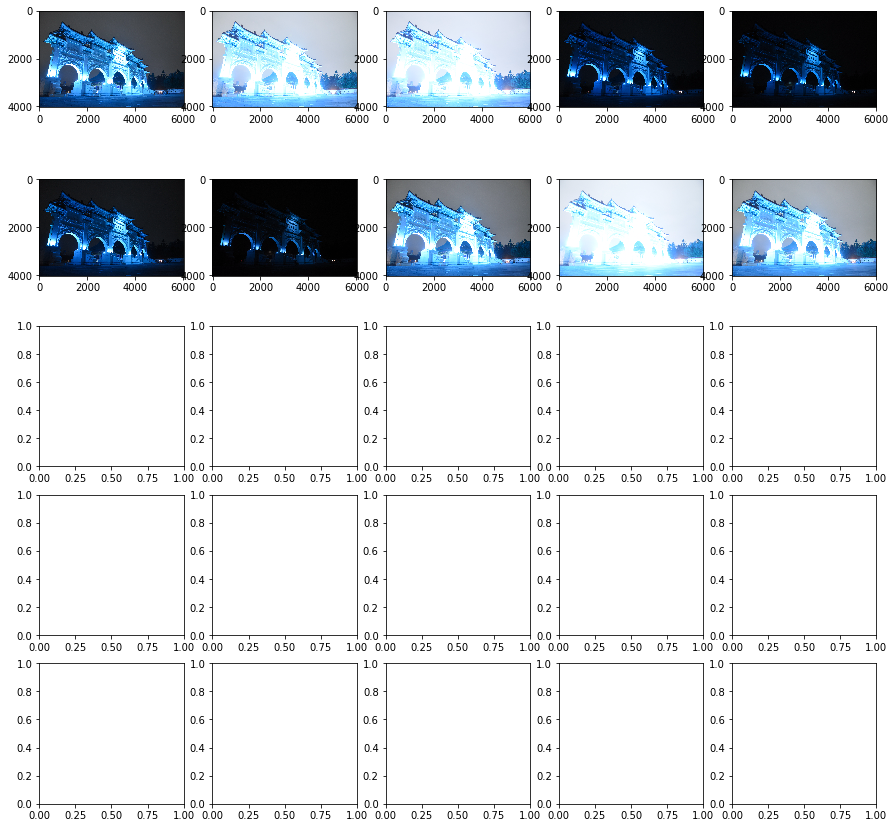

No handles with labels found to put in legend.


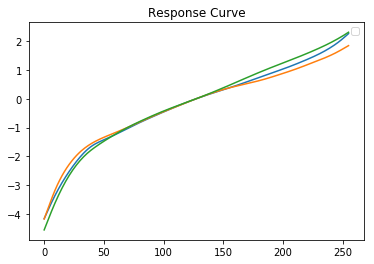

In [63]:
if __name__ == "__main__":
    images, images_rgb = readImages("testing_images/View2")
    show_images(images)
    # living_room_times = np.array([1/160, 1/125, 1/80, 1/60, 1/40, 1/15], dtype = float)
    view_2_times = np.array([1, 10, 15, 1 / 10, 1 / 25, 
                             1 / 5, 1 / 50, 2.5, 20, 5])
    view_1_times = np.array([1, 10, 15, 1 / 10, 1 / 2.5, 1 / 25, 
                             1 / 5, 20, 5])
    complete_view_1_times = np.array([1, 20, 15, 1/10, 1/100, 1/125, 1/160, 1/2.5, 1/25, 
                                     1/250, 1/400, 1/5, 1/50, 1/80, 1/800, 20, 25, 5])
    #test_times = np.array([60, 80, 100, 125, 160, 200, 250, 320, 400, 500, 800, 1250, 2000, 3200], dtype = float)
    #test_times = test_times[::-1]
    #living_room_times = np.array([32, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.15625, 0.0078125, 0.00390625, 0.001953125, 0.0009765265], dtype = float)
    #living_room_times = living_room_times[::-1]
    # living_room_times = np.log(living_room_times)
    result_image, RadianceMap = CreateHdrImage(
                                   images_rgb, 
                                   MAX_intensity = 255, 
                                   shutter_times = np.log(view_2_times),#test_times[-10: -1], 
                                   WeightedIntensity = intensity_weighting, 
                                   ToneMappingFunction = gammaToneMapping, 
                                   RadMap = []
                                )
    for i in tqdm(range(len(result_image))):
        for j in range(len(result_image[0])):
            if(result_image[i][j][0] > 230):
                result_image[i][j][1]  = result_image[i][j][2] = result_image[i][j][0]
    # cv2.imwrite("result_images/normalize.png", result_image)

In [55]:
np.exp(np.max(RadianceMap))

107.3439862817477

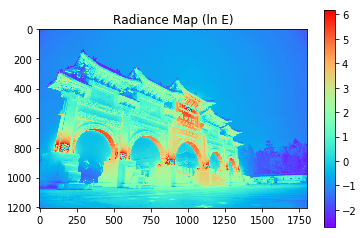

In [64]:
# plt.imshow(cv2.normalize(np.exp(RadianceMap[0]), np.array([]), alpha=0, beta=255, norm_type=cv2.NORM_MINMAX), 
#            origin="lower", cmap='Spectral', interpolation='nearest')
plt.imshow(RadianceMap[0], 
           origin="lower", cmap='rainbow', interpolation='nearest')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Radiance Map (ln E)")
plt.savefig("result_images/smallsizeRmap2.png", dpi = 300)
plt.show()


In [29]:
for i in range(3):
    RadianceMap[i] = np.clip(RadianceMap[i], -10, 0)